In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

% matplotlib inline

from scipy.stats import mode

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report,\
confusion_matrix, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [2]:
bidsdf = pd.read_csv('bids.csv')
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

print('bidsdf shape: {}'.format(bidsdf.shape))
print('traindf shape: {}'.format(traindf.shape))
print('testdf shape: {}'.format(testdf.shape))

bidsdf shape: (7656334, 9)
traindf shape: (2013, 4)
testdf shape: (4700, 3)


## EDA

In [3]:
# bidsdf data types 
bidsdf.dtypes

bid_id          int64
bidder_id      object
auction        object
merchandise    object
device         object
time            int64
country        object
ip             object
url            object
dtype: object

In [4]:
# check for null values
bidsdf.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

## Feature Engineering (hypotheses regarding robotic behaviour):
    - Quantity: robots submit more bids per auction
    - Speed: robots submit bids faster than humans
    
    We engineered four features:
    1) bids_fnum: robots submit more bids
    2) auctions_fnum: robots submit more bids across auctions
    3) meanbidsperauction_fnum: hence, mean bids per auction for robots should be higher
    4) meantimediff_fnum: robots has faster submission time

#### <font color='red'> Engineering features
    - bids_fnum
    - auctions_fnum
    - meanbidsperauction_fnum

In [5]:
# sort bidsdf by 'bidder_id' and 'time' in ascending order
bidsdf = bidsdf.sort_values(['bidder_id','time'],ascending=[True,True]).reset_index(drop=True)

In [6]:
# bidsdf head
bidsdf.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,7179832,001068c415025a009fee375a12cff4fcnht8y,4ifac,jewelry,phone561,9706345052631578,bn,139.226.147.115,vasstdc27m7nks3
1,1281292,002d229ffb247009810828f648afc2ef593rb,2tdw2,mobile,phone640,9766744105263157,sg,37.40.254.131,vasstdc27m7nks3
2,1281311,002d229ffb247009810828f648afc2ef593rb,2tdw2,mobile,phone219,9766744210526315,sg,37.40.254.131,vasstdc27m7nks3
3,6805028,0030a2dd87ad2733e0873062e4f83954mkj86,obbny,mobile,phone313,9704553947368421,ir,21.67.17.162,vnw40k8zzokijsv
4,3967330,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,obbny,mobile,phone420,9640018631578947,id,44.241.8.179,sj4jidex850loas


In [7]:
# mean bids per unique auction - bids (new dataframe)
# count the no. of bids each bidder_id participated in
bids = bidsdf.groupby('bidder_id')['bidder_id'].agg('count')

bids = pd.DataFrame({'bidder_id':bids.index,'bids_fnum':bids.values},index=bids.index)
bids.index.name = ''

# count the no. of unique auctions each bidder_id participated in
auction = bidsdf.groupby('bidder_id')['auction'].nunique()

bids['auctions_fnum'] = auction

# mean no. of bids per unique auction
bids['meanbidsperauction_fnum'] = bids['bids_fnum'] / bids['auctions_fnum']

print('bids shape: {}'.format(bids.shape))

bids shape: (6614, 4)


In [8]:
# concat 'target' to bids dataframe
bids['outcome'] = traindf.groupby('bidder_id')['outcome'].mean()

print('bids shape: {}'.format(bids.shape),'\n')

# filter for train set from bids dataframe
bidstraindf = bids[(bids['outcome'] == 0) | (bids['outcome'] == 1)]

print('bidstraindf shape: {}'.format(bidstraindf.shape))

bids shape: (6614, 5) 

bidstraindf shape: (1984, 5)


## Visualizations (related to number of bids and unique auctions):
    - Mean no. of bids per auction with outliers
    - Mean no. of bids per auction without outliers
    - Average for mean no. of bids per auction

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


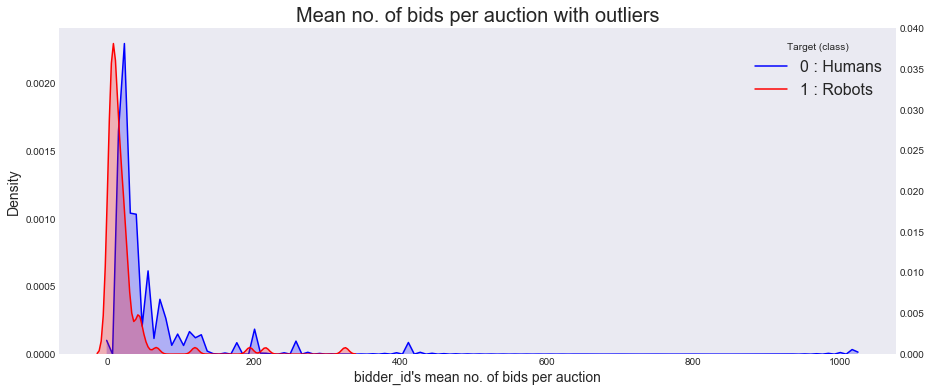

In [53]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

ax1 = sns.kdeplot(bidstraindf[bidstraindf['outcome'] == 0]['meanbidsperauction_fnum'],shade=True,color='b',
                  label='0 : Humans',legend=True)

ax2 = ax1.twinx()
ax2 = sns.kdeplot(bidstraindf[bidstraindf['outcome'] == 1]['meanbidsperauction_fnum'],shade=True,color='r',
                  legend=False)

ax1.plot(np.nan,'r',label='1 : Robots')
ax1.legend(title='Target (class)',fontsize=16,loc='best')

# adding title and x,y labels for plot
ax1.set_title('Mean no. of bids per auction with outliers',fontsize=20)
ax1.set_xlabel('bidder_id\'s mean no. of bids per auction',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)

ax.grid(False)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


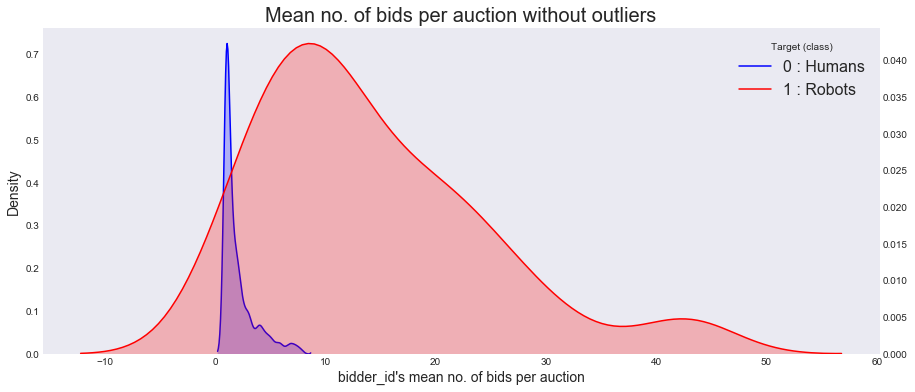

In [54]:
# removing outliers from 'meanbidsperauction_fnum' in bidstraindf
q25_h,q75_h = np.percentile(bidstraindf[bidstraindf['outcome'] == 0]['meanbidsperauction_fnum'],25), np.percentile(bidstraindf[bidstraindf['outcome'] == 0]['meanbidsperauction_fnum'],75)
iqr_h = q75_h-q25_h

q25_r,q75_r = np.percentile(bidstraindf[bidstraindf['outcome'] == 1]['meanbidsperauction_fnum'],25), np.percentile(bidstraindf[bidstraindf['outcome'] == 1]['meanbidsperauction_fnum'],75)
iqr_r = q75_r-q25_r

# calculate the outlier cutoff (using 1.5x as the upper and lower limit)
cutoff_h = iqr_h * 1.5
lwr_h, upr_h = q25_h - cutoff_h, q75_h + cutoff_h

cutoff_r = iqr_r * 1.5
lwr_r, upr_r = q25_r - cutoff_r, q75_r + cutoff_r

# segregating humans and robots 'meanbidsperauction_fnum' info
bidstrain0 = bidstraindf[bidstraindf['outcome'] == 0]['meanbidsperauction_fnum'].reset_index(drop=True)
bidstrain1 = bidstraindf[bidstraindf['outcome'] == 1]['meanbidsperauction_fnum'].reset_index(drop=True)

# indexes for outliers for lwr and upr
outliers_index_h = [i for i,x in enumerate(list(bidstrain0)) if x < lwr_h or x > upr_h]
outliers_index_r = [i for i,x in enumerate(list(bidstrain1)) if x < lwr_r or x > upr_r]

# plotting
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

ax1 = sns.kdeplot(bidstrain0[~bidstrain0.index.isin(outliers_index_h)],shade=True,color='b',
                  label='0 : Humans',legend=True)

ax2 = ax1.twinx()
ax2 = sns.kdeplot(bidstrain1[~bidstrain1.index.isin(outliers_index_r)],shade=True,color='r',
                  legend=False)

ax1.plot(np.nan,'r',label='1 : Robots')
ax1.legend(title='Target (class)',fontsize=16,loc='best')

# adding title and x,y labels for plot
ax1.set_title('Mean no. of bids per auction without outliers',fontsize=20) 
ax1.set_xlabel('bidder_id\'s mean no. of bids per auction',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)

ax.grid(False)

average of 'meanbidsperauction_fnum' for class 0 - humans: 6.442
average of 'meanbidsperauction_fnum' for class 1 - robots: 23.155





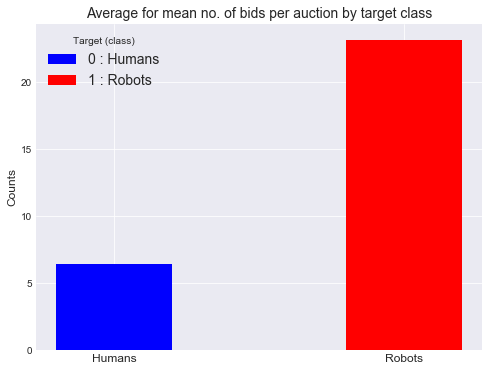

In [59]:
# taking average of 'meanbidsperauction_fnum' from bids_train df
avg0 = bidstraindf[bidstraindf['outcome'] == 0]['meanbidsperauction_fnum'].mean()
avg1 = bidstraindf[bidstraindf['outcome'] == 1]['meanbidsperauction_fnum'].mean()

print('average of \'meanbidsperauction_fnum\' for class 0 - humans: {}'.format(round(avg0,3),'\n'))
print('average of \'meanbidsperauction_fnum\' for class 1 - robots: {}'.format(round(avg1,3),'\n'))
print('')
print('')
print('')

# barplot for avg0 and avg1
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(1,avg0,0.08,color='b')
ax.bar(1.2,avg1,0.08,color='r')

ax.set_xticks((1,1.2))
ax.set_xticklabels(('Humans','Robots'),fontsize=12)

ax.set_ylabel('Counts',fontsize=12)
ax.set_title('Average for mean no. of bids per auction by target class',fontsize=14)
ax.legend(['0 : Humans','1 : Robots'],title='Target (class)',loc='best',fontsize=14)

ax.grid(True)

## Visualizations (related to time difference):
    - Time difference (lag = 1) and compare with two cases for time diff: 
    1) 0 to 0.6 * 1e13
    2) 4.5 * 1e13 to 6.0 * 1e13

In [12]:
# time difference between consecutive bids for each 'bidder_id'
timediff_num = bidsdf.groupby('bidder_id')['time'].diff()
timediff_num = timediff_num.values.reshape(-1,1)

bids_index = bidsdf['bidder_id']

# create dataframe
timedf = pd.DataFrame({'bidder_id':bids_index,'timediff_num':timediff_num.reshape(-1)})
        
timedf = pd.merge(timedf,traindf.loc[:,['bidder_id','outcome']],on='bidder_id',how='inner')
timedf = timedf.astype({'outcome':int})

print('timedf shape: {}'.format(timedf.shape))

timedf shape: (3071224, 3)


C:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


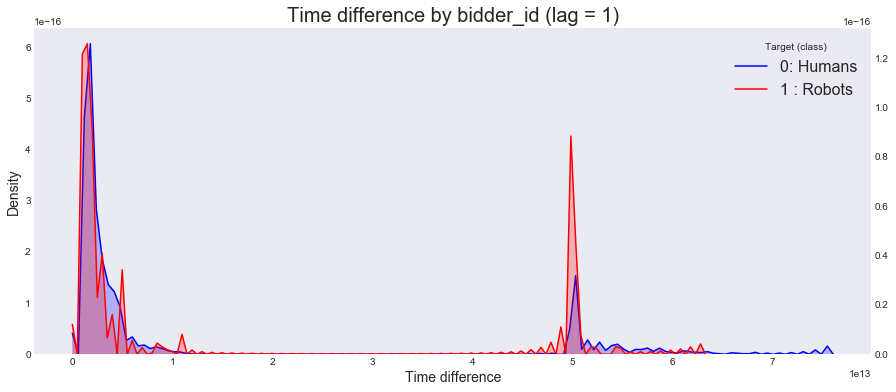

In [56]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

ax1 = sns.kdeplot(timedf[timedf['outcome'] == 0]['timediff_num'],shade=True,color='b',
                  label='0: Humans',legend=False)

ax2 = ax1.twinx()
ax2 = sns.kdeplot(timedf[timedf['outcome'] == 1]['timediff_num'],shade=True,color='r',
                  legend=False)

ax1.plot(np.nan,'r',label='1 : Robots')
ax1.legend(title='Target (class)',fontsize=16,loc='best')

# adding title and x,y labels for plot
ax1.set_title('Time difference by bidder_id (lag = 1)',fontsize=20)
ax1.set_xlabel('Time difference',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)

ax.grid(False)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


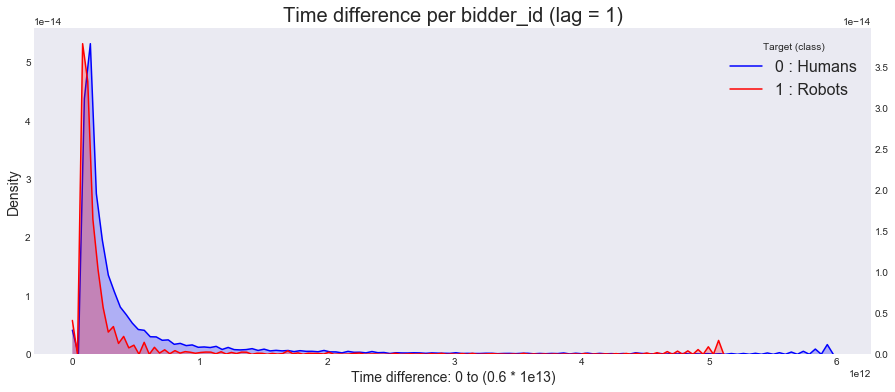

In [57]:
# 0 to 0.6 * 1e13
timediff002 = timedf[(timedf['timediff_num'] >= 0) & (timedf['timediff_num'] <= 0.6*1e13)]

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

ax1 = sns.kdeplot(timediff002[timediff002['outcome'] == 0]['timediff_num'],shade=True,color='b',
                  label='0 : Humans',legend=False)

ax2 = ax1.twinx()
ax2 = sns.kdeplot(timediff002[timediff002['outcome'] == 1]['timediff_num'],shade=True,color='r',
                  legend=False)

ax1.plot(np.nan,'r',label='1 : Robots')
ax1.legend(title='Target (class)',fontsize=16,loc='best')

# adding title and x,y labels for plot
ax1.set_title('Time difference per bidder_id (lag = 1)',fontsize=20)
ax1.set_xlabel('Time difference: 0 to (0.6 * 1e13)',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)

ax.grid(False)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


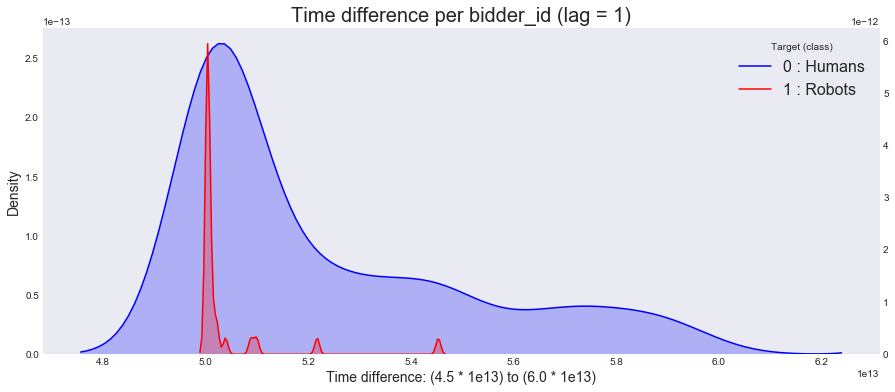

In [58]:
# 0 to 0.6 * 1e13
timediff002 = timedf[(timedf['timediff_num'] >= 4.5*1e13) & (timedf['timediff_num'] <= 6.0*1e13)]

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)

ax1 = sns.kdeplot(timediff002[timediff002['outcome'] == 0]['timediff_num'],shade=True,color='b',
                  label='0 : Humans',legend=False)

ax2 = ax1.twinx()
ax2 = sns.kdeplot(timediff002[timediff002['outcome'] == 1]['timediff_num'],shade=True,color='r',
                  legend=False)

ax1.plot(np.nan,'r',label='1 : Robots')
ax1.legend(title='Target (class)',fontsize=16,loc='best')

# adding title and x,y labels for plot
ax1.set_title('Time difference per bidder_id (lag = 1)',fontsize=20)
ax1.set_xlabel('Time difference: (4.5 * 1e13) to (6.0 * 1e13)',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)

ax.grid(False)

#### <font color='red'> Engineering Features
    - meantimediff_fnum

In [16]:
# concat 'meantimediff_fnum' to bidsdf and prepare our training data before modelling
# taking time difference with lag = 1
timediff = bidsdf.groupby('bidder_id')['time'].diff()

# feature scaling for timediff for LogisticRegression modelling
mms = MinMaxScaler()
timediff_norm = mms.fit_transform(np.array(timediff).reshape(-1,1))

# concat timediff and timediff_norm to bidsdf
bidsdf['timediff'] = timediff
bidsdf['timediff_norm'] = timediff_norm

# impute missing values in timediff and timediff_norm with their medians
# median is chosen as timediff and timediff_norm are right-skewed distributions
bidsdf['timediff'] = bidsdf['timediff'].fillna(bidsdf['timediff'].median())
bidsdf['timediff_norm'] = bidsdf['timediff_norm'].fillna(bidsdf['timediff_norm'].median())

print('bidsdf shape: {}'.format(bidsdf.shape))

bidsdf shape: (7656334, 11)


In [17]:
# taking the mean of timediff_norm and concat vertically to bids dataframe
meandiff_norm = bidsdf.groupby('bidder_id')['timediff_norm'].mean()

bids['meantimediff_norm_fnum'] = meandiff_norm

print('bids shape: {}'.format(bids.shape))

bids shape: (6614, 6)


## Baseline
    One that always predicts the majority class of 0 : Humans
    - Without down- or up- sampling of this imbalanced dataset
    - AUC: 0.50

In [18]:
# baseline model fitting
train = bids[(bids['outcome'] == 0 ) | (bids['outcome'] == 1)]

X = train.drop(['bidder_id','outcome'],axis=1,inplace=False)
y = train['outcome']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=42)

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(xtrain,ytrain)

ypred = logreg.predict(xtest)

fpr,tpr,_ = roc_curve(ytest,np.zeros(ytest.shape[0]))

print('baseline auc: {}'.format(auc(fpr,tpr)))

baseline auc: 0.5


In [19]:
# to shift 'outcome' column to last index and remove 'bidder_id' from bids dataframe
# reason being - so that we can use the following customized functions for model fitting
cols = bids.columns.tolist()
cols.pop(cols.index('outcome'))

bids = bids[cols+['outcome']]

# create new dataframe to drop 'bidder_id' and subsequently, change the dataframe to array
bids_array = bids.copy()
bids_array.drop('bidder_id',axis=1,inplace=True)

# change bids dataframe to bids array
bids_array = bids_array.values

print('bids shape: {}'.format(bids.shape),'\n')
print('bids_array shape: {}'.format(bids_array.shape))

bids shape: (6614, 6) 

bids_array shape: (6614, 5)


### Creating following functions for convenience in computing of model evaluation metrics, downsampling of majority class of 0 : Humans and upsampling of minority class of 1 : Robots

In [20]:
# to shift 'outcome' column to last index in bids dataframe
# to remove 'bidder_id' column from bids_array (a copy of bids) and subsequently, change it to an array for model fitting
def df_to_array(df):
    '''descr'''
    
    cols = df.columns.tolist()
    cols.pop(cols.index('outcome'))
    
    df = df[cols+['outcome']]
    
    # create a copy of df and remove 'bidder_id' column
    data_array = df.copy()
    data_array.drop('bidder_id',axis=1,inplace=True)
    
    # change data structure
    data_array = data_array.values
    
    return data_array

In [21]:
# score func for evaluating classifier's accuracy, precision and recall
def score(x_test,y_test,y_pred):
    '''score function for evaluating classifier\'s accuracy, precision and recall'''
    acc = model.score(x_test,y_test)
    prec = precision_score(y_test,y_pred)
    recal = recall_score(y_test,y_pred)
    
    return acc,prec,recal

In [22]:
# downsampling func for this imbalanced dataset
def downsample(data_array):
    '''downsammpling function for majority class of 0 : Humans to 50:50 ratio against 1 : Robots'''
    bids0 = resample(data_array[data_array[:,-1] == 0,:],replace=True,
                     n_samples=pd.Series(data_array[:,-1]).value_counts()[1],random_state=42)
    
    bids1 = data_array[data_array[:,-1] == 1,:]
    
    bidsdownsample = np.vstack((bids0,bids1))
    
    fold_xtrain = bidsdownsample[:,:-1]
    fold_ytrain = bidsdownsample[:,-1]
    
    return fold_xtrain,fold_ytrain

In [23]:
# upsampling func for this imbalanced dataset
def upsample(data_array):
    '''upsampling function for minority class of 1 : Robots to 50:50 ratio against 0 : Humans'''
    
    bids0 = data_array[data_array[:,-1] == 0,:]
    
    bids1 = resample(data_array[data_array[:,-1] == 1,:],replace=True,
                    n_samples=pd.Series(data_array[:,-1]).value_counts()[0],random_state=42)
    
    bidsupsample = np.vstack((bids0,bids1))
    
    fold_xtrain = bidsupsample[:,:-1]
    fold_ytrain = bidsupsample[:,-1]
    
    return fold_xtrain,fold_ytrain

In [24]:
def kfcv_downsample(model,data_array,fold=5):
    '''stratified k-fold cross-validation with default 5 folds and for downsampling of majority class - 0 : Humans'''
    
    # filtering for training data from data_array
    train0 = data_array[data_array[:,-1] == 0,:]
    train1 = data_array[data_array[:,-1] == 1,:]
    train = np.vstack((train0,train1))
    
    x = train[:,:-1]
    y = train[:,-1]
    
    # cross-validation
    aucs = []
    accuracies = []
    precisions = []
    recalls = []
    
    kf = StratifiedKFold(fold,shuffle=False,random_state=42)

    for train_indices,test_indices in kf.split(x,y):
        fold_xtrain = x[train_indices]
        fold_xtest = x[test_indices]
        fold_ytrain = y[train_indices]
        fold_ytest = y[test_indices]

        # creating a data array for training set in each fold
        train_array = np.hstack((fold_xtrain,fold_ytrain.reshape(-1,1)))
    
        # downsampling majority class of 0 : Humans
        fold_xtrain,fold_ytrain = downsample(train_array)
    
        # model fitting
        model.fit(fold_xtrain,fold_ytrain)
  
        # predict target and computing its associated probabilities
        ypred = model.predict(fold_xtest)
        yprob = model.predict_proba(fold_xtest)
        
        ypp = pd.DataFrame(yprob,columns=['class0pr','class1pr'])
        
        # lower the probability threshold for predicting class 1 : Robots
        #ypp['class1newpr_pred'] = [1 if x >= prob else 0 for x in ypp['class1pr']]

        # for class 1 : Robots, find its auc
        fpr,tpr,_ = roc_curve(fold_ytest,ypp['class1pr'])
        aucs.append(auc(fpr,tpr))

        # computing accuracies, precisions, recalls
        acc,prec,recal = score(fold_xtest,fold_ytest,ypred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(recal)
    
    prob = 0.5
    auc_mean = round(np.mean(aucs),5)
    acc_mean = round(np.mean(accuracies),5)
    prec_mean = round(np.mean(precisions),5)
    recall_mean = round(np.mean(recalls),5)
    
    return [prob,auc_mean,acc_mean,prec_mean,recall_mean]

In [25]:
def kfcv_upsample(model,data_array,fold=5):
    '''stratified k-fold cross-validation with default 5 folds and for upsampling of majority class - 1 : Robots'''
    
    # filtering for training data from data_array
    train0 = data_array[data_array[:,-1] == 0,:]
    train1 = data_array[data_array[:,-1] == 1,:]
    train = np.vstack((train0,train1))
    
    x = train[:,:-1]
    y = train[:,-1]
    
    # cross-validation
    aucs = []
    accuracies = []
    precisions = []
    recalls = []
    
    kf = StratifiedKFold(fold,shuffle=False,random_state=42)

    for train_indices,test_indices in kf.split(x,y):
        fold_xtrain = x[train_indices]
        fold_xtest = x[test_indices]
        fold_ytrain = y[train_indices]
        fold_ytest = y[test_indices]

        # creating a data array for training set in each fold
        train_array = np.hstack((fold_xtrain,fold_ytrain.reshape(-1,1)))
    
        # upsampling minority class of 1 : Robots
        fold_xtrain,fold_ytrain = upsample(train_array)
    
        # model fitting
        model.fit(fold_xtrain,fold_ytrain)
  
        # predict target and computing its associated probabilities
        ypred = model.predict(fold_xtest)
        yprob = model.predict_proba(fold_xtest)
        
        ypp = pd.DataFrame(yprob,columns=['class0pr','class1pr'])
        
        # lower the probability threshold for predicting class 1 : Robots
        #ypp['class1newpr_pred'] = [1 if x >= prob else 0 for x in ypp['class1pr']]

        # for class 1 : Robots, find its auc
        fpr,tpr,_ = roc_curve(fold_ytest,ypp['class1pr'])
        aucs.append(auc(fpr,tpr))

        # computing accuracies, precisions, recalls
        acc,prec,recal = score(fold_xtest,fold_ytest,ypred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(recal)

    prob = 0.5
    auc_mean = round(np.mean(aucs),5)
    acc_mean = round(np.mean(accuracies),5)
    prec_mean = round(np.mean(precisions),5)
    recall_mean = round(np.mean(recalls),5)
    
    return [prob,auc_mean,acc_mean,prec_mean,recall_mean]

## <font color='green'> Modelling
    LogisticRegression with four features
    1) bids_fnum
    2) auctions_fnum
    3) meanbidsperauction_fnum
    4) meantimediff_norm_fnum

In [26]:
# logistic regression and downsampling
model = LogisticRegression(solver='lbfgs')

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_downsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.80978,0.83772,0.16334,0.50571


In [27]:
# logistic regression and downsampling
model = LogisticRegression(solver='lbfgs')

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_upsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.83627,0.84226,0.19568,0.65


## <font color='green'> Modelling
    RandomForestClassifier with four features
    1) bids_fnum
    2) auctions_fnum
    3) meanbidsperauction_fnum
    4) meantimediff_fnum

In [28]:
# replacing meantimediff_norm_fnum with meantimediff_fnum in bids dataframe
bids = bids.drop('meantimediff_norm_fnum',axis=1,inplace=False)

# taking the mean of timediff and concat vertically to bids dataframe
meandiff = bidsdf.groupby('bidder_id')['timediff'].mean()

bids['meantimediff_fnum'] = meandiff

In [29]:
# randomforestclassifier and downsampling
model = RandomForestClassifier(random_state=42)

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_downsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.88489,0.80495,0.18638,0.75857


In [30]:
# randomforestclassifier and upsampling
model = RandomForestClassifier(random_state=42)

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_upsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.76165,0.94003,0.40636,0.34905


## Feature Engineering (more time- and timedifffrelated features):
    - timemax_fnum
    - timemin_fnum
    
    - timediffmax_fnum
    - timediffmin_fnum
    - timediffrange_fnum
    - timediffmean_fnum
    - timediffmedian_fnum
    - timediffquantile_0.1_fnum to timediffquantile_0.9_fnum

#### <font color='red'> Engineering features
    - timemax_fnum
    - timemin_fnum

In [31]:
# max time feature
timemax = bidsdf.groupby('bidder_id')['time'].max()

bids['timemax_fnum'] = timemax

# min time feature
timemin = bidsdf.groupby('bidder_id')['time'].min()

bids['timemin_fnum'] = timemin

### Keeping null values for timediff column for train and test sets so that we can apply appropriate imputation (i.e. median) for missing values in timediff-related engineered features

In [32]:
timediffnull = bidsdf.groupby('bidder_id')['time'].diff()
bidsdf['timediffnull'] = timediffnull

#### <font color='red'> Engineering features
    - timediffmax_fnum
    - timediffmin_fnum
    - timediffrange_fnum
    - timediffmean_fnum
    - timediffmedian_fnum
    - timediffquantile_0.1_fnum to timediffquantile_0.9_fnum

In [33]:
# timediffnull - max
bids['timediffmax_fnum'] = bidsdf.groupby('bidder_id')['timediffnull'].max()
bids['timediffmax_fnum'] = bids['timediffmax_fnum'].fillna(bids['timediffmax_fnum'].median())

# timediffnull - min
bids['timediffmin_fnum'] = bidsdf.groupby('bidder_id')['timediffnull'].min()
bids['timediffmin_fnum'] = bids['timediffmin_fnum'].fillna(bids['timediffmin_fnum'].median())

# timediffnull - range
bids['timediffrange_fnum'] = bids['timediffmax_fnum'] - bids['timediffmin_fnum']

# timediffnull - mean
bids['timediffmean_fnum'] = bidsdf.groupby('bidder_id')['timediffnull'].mean()
bids['timediffmean_fnum'] = bids['timediffmean_fnum'].fillna(bids['timediffmean_fnum'].median())

# timediffnull - median
bids['timediffmedian_fnum'] = bidsdf.groupby('bidder_id')['timediffnull'].median()
bids['timediffmedian_fnum'] = bids['timediffmedian_fnum'].fillna(bids['timediffmedian_fnum'].median())

# timediffnull - quantiles
for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    q_str = 'timediffquantile' + str(q) + '_fnum'
    
    bids[q_str] = bidsdf.groupby('bidder_id')['timediffnull'].quantile(q)
    bids[q_str] = bids[q_str].fillna(bids[q_str].median())

print('bids shape: {}'.format(bids.shape))

bids shape: (6614, 22)


## <font color='green'> Modelling
    RandomForestClassifier with twenty features:
    - bids_fnum
    - auctions_fnum
    - meanbidsperauction_fnum
    - meantimediff_fnum
    
    - timemax_fnum
    - timemin_fnum
    
    - timediffmax_fnum
    - timediffmin_fnum
    - timediffrange_fnum
    - timediffmean_fnum
    - timediffmedian_fnum
    - timediffquantile_0.1_fnum to timediffquantile_0.9_fnum

In [34]:
# randomforestclassifier and downsampling
model = RandomForestClassifier(random_state=42)

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_downsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.87862,0.81198,0.20097,0.87429


In [35]:
# randomforestclassifier and upsampling
model = RandomForestClassifier(random_state=42)

bids_array = df_to_array(bids)

summary = pd.DataFrame(np.array(kfcv_upsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.83002,0.94454,0.47059,0.31952


# Vectorizing Text Data
    - to see if there are any defining characteristics that would differentiate robotic behaviour from human behaviour
    
    - note that for predictive modeling, 'payment_account' and 'address' text columns are left out for vectorization as they had mediocre AUC scores from our univariate AUC score analyses

In [36]:
textcols = ['auction','merchandise','device','country','ip','url','timedifftext']

# aggregating text features in bidstraindf
bidstextdf = bidsdf.groupby('bidder_id')['bidder_id'].agg('count')
bidstextdf = pd.DataFrame({'bidder_id':bidstextdf.index,'bids_num':bidstextdf.values},index=bidstextdf.index)

# as there are some data points in 'country' that are float, we are converting them to string here
bidsdf['country'] = bidsdf['country'].apply(lambda x: str(x))

# adding in a new text column for timediff as there are some patterns distinctive to robots
bidsdf['timedifftext'] = bidsdf['timediff'].apply(lambda x: str(x))

for var in textcols:
    var_text = var + '_ftext' 
    var_num = var + '_fnum'

    bidstextdf[var_text] = bidsdf.groupby('bidder_id')[var].apply(lambda x: ' '.join(x))
    bidstextdf[var_num] = bidsdf.groupby('bidder_id')[var].nunique()

print('bidstextdf shape: {}'.format(bidstextdf.shape))

bidstextdf shape: (6614, 16)


#### <font color='red'> Engineering features
    - Text vectorization with the following instructions:
    
    - CountVectorizer()
    - Our own customizer tokenizer defined by tokensvect()
    - 'payment_account' and 'address' would not be vectorized
    - 'IP' would be vectorized using default tokenizer defined within sklearn's CountVectorizer(). The reason is because due to analysis done (not in this notebook), our customized tokenizer returned meaningless univariate AUC scores

In [37]:
# define my own tokenizer specific for this problem
def tokensvect(x):
    return x.split(' ')

In [38]:
# setting up the text CountVectorizer's parameters dictionary
textparams = {}

textparams['auction_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':8,'ngram':(1,1)}
textparams['merchandise_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':1,'ngram':(1,7)}
textparams['device_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':6,'ngram':(1,1)}
textparams['country_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':6,'ngram':(1,1)}
textparams['ip_ftext'] = {'include':True,'tokenizer':'default','mindf':1,'ngram':(1,1)}
textparams['url_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':8,'ngram':(1,1)}
textparams['timedifftext_ftext'] = {'include':True,'tokenizer':'tokensvect','mindf':4,'ngram':(1,1)}

#### Changing the data structures for our train and test dataframes to arrays so that we can apply np.hstack() later with our vectorized text predictors

In [39]:
bids['index'] = range(bids.shape[0])
bidstextdf['index'] = range(bidstextdf.shape[0])

outcome0_index = bids[bids['outcome'] == 0]['index']
outcome1_index = bids[bids['outcome'] == 1]['index']

# split bids df to train set
train = bids[(bids['outcome'] == 0) | (bids['outcome'] == 1)]
train_index = train['index']

xtrainall = train.drop(['bidder_id','outcome','index'],axis=1,inplace=False).values
ytrainall = train['outcome'].values.reshape(-1,1)

# split bids df to test set
test = bids[bids['outcome'].isna()]
test_index = test['index']

xtestall = test.drop(['bidder_id','outcome','index'],axis=1,inplace=False).values

print('xtrainall shape: {}'.format(xtrainall.shape),'\n')
print('ytrainall shape: {}'.format(ytrainall.shape),'\n')
print('xtestall shape: {}'.format(xtestall.shape))

xtrainall shape: (1984, 20) 

ytrainall shape: (1984, 1) 

xtestall shape: (4630, 20)


In [40]:
textcols = ['auction_ftext','merchandise_ftext','device_ftext',
            'country_ftext','ip_ftext','url_ftext','timedifftext_ftext']

cvect_feature_names = []

for col in textcols:
    xtrainfeature = 0
    xtestfeature = 0
    
    if textparams[col]['include'] is not True:
        continue
    else:
        if textparams[col]['tokenizer'] is 'tokensvect':
            cvect = CountVectorizer(tokenizer=tokensvect,min_df=textparams[col]['mindf'],
                                    ngram_range=textparams[col]['ngram'])
            
            xtrainfeature = cvect.fit_transform(bidstextdf[bidstextdf['index'].isin(train_index)][col])
            xtestfeature = cvect.transform(bidstextdf[bidstextdf['index'].isin(test_index)][col])

            print(col + ' xtrainfeature shape: {}'.format(xtrainfeature.shape))
            print(col + ' xtestfeature shape: {}'.format(xtestfeature.shape),'\n')
        else:
            cvect = CountVectorizer(min_df=textparams[col]['mindf'],
                                   ngram_range=textparams[col]['ngram'])
            
            xtrainfeature = cvect.fit_transform(bidstextdf[bidstextdf['index'].isin(train_index)][col])
            xtestfeature = cvect.transform(bidstextdf[bidstextdf['index'].isin(test_index)][col])
            
            print(col + ' xtrainfeature shape: {}'.format(xtrainfeature.shape))
            print(col + ' xtestfeature shape: {}'.format(xtestfeature.shape),'\n')
        
    # append cvect feature names
    cvect_feature_names.append(cvect.get_feature_names())
            
    ####-------------------------------------------- Train set --------------------------------------------###    
    xtrainfeature = xtrainfeature.toarray()
    xtrainall = np.hstack((xtrainall,xtrainfeature))    
    
    ####-------------------------------------------- Test set --------------------------------------------###
    xtestfeature = xtestfeature.toarray()
    xtestall = np.hstack((xtestall,xtestfeature))
    
print('xtrainall shape: {}'.format(xtrainall.shape))
print('xtestall shape: {}'.format(xtestall.shape))
print('cvect feature names len: {}'.format(len(cvect_feature_names)))

auction_ftext xtrainfeature shape: (1984, 4158)
auction_ftext xtestfeature shape: (4630, 4158) 

merchandise_ftext xtrainfeature shape: (1984, 132)
merchandise_ftext xtestfeature shape: (4630, 132) 

device_ftext xtrainfeature shape: (1984, 2482)
device_ftext xtestfeature shape: (4630, 2482) 

country_ftext xtrainfeature shape: (1984, 174)
country_ftext xtestfeature shape: (4630, 174) 

ip_ftext xtrainfeature shape: (1984, 246)
ip_ftext xtestfeature shape: (4630, 246) 

url_ftext xtrainfeature shape: (1984, 12)
url_ftext xtestfeature shape: (4630, 12) 

timedifftext_ftext xtrainfeature shape: (1984, 5364)
timedifftext_ftext xtestfeature shape: (4630, 5364) 

xtrainall shape: (1984, 12588)
xtestall shape: (4630, 12588)
cvect feature names len: 7


#### Adding '_fnum' text features (the unique counts for each text object for each bidder_id in each text column) to xtrainall and xtestall

In [41]:
textcols = ['auction_fnum','merchandise_fnum','device_fnum','country_fnum',
           'ip_fnum','url_fnum','timedifftext_fnum']

trainfnum = bidstextdf[bidstextdf['index'].isin(train_index)][textcols]
testfnum = bidstextdf[bidstextdf['index'].isin(test_index)][textcols]

print('trainfnum shape: {}'.format(trainfnum.shape),'\n')
print('testfnum shape: {}'.format(testfnum.shape),'\n')

# horizontal concat to xtrainall and xtestall
xtrainall = np.hstack((xtrainall,trainfnum.values))
xtestall = np.hstack((xtestall,testfnum.values))

print('xtrainall shape: {}'.format(xtrainall.shape),'\n')
print('xtestall shape: {}'.format(xtestall.shape),'\n')
print('ytrainall shape: {}'.format(ytrainall.shape))

trainfnum shape: (1984, 7) 

testfnum shape: (4630, 7) 

xtrainall shape: (1984, 12595) 

xtestall shape: (4630, 12595) 

ytrainall shape: (1984, 1)


#### <font color='red'> Visualizing text data
    - once text data has been vectorized, we calculated the number of counts for each text object across all unique bidders (robot or human) for all text data

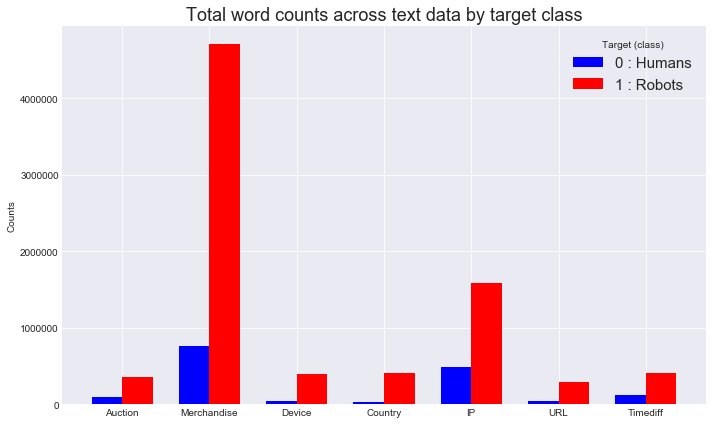

In [60]:
counts0 = [95792,757457,44730,30857,482829,43388,116215]
counts1 = [355748,4704950,402286,412177,1585226,292379,411680]

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 7
index = np.arange(n_groups)
bar_width = 0.35

rects1 = ax.bar(index,counts0,bar_width,color='b')
rects2 = ax.bar(index+bar_width,counts1,bar_width,color='r')

ax.set_ylabel('Counts')
ax.set_title('Total word counts across text data by target class',fontsize=18)
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels(('Auction','Merchandise','Device','Country','IP','URL','Timediff'))
ax.legend(['0 : Humans','1 : Robots'],title='Target (class)',loc='best',fontsize=15)

fig.tight_layout()

ax.grid(True)

## <font color='green'> Modelling
    RandomForestClassifier with the following features:
    - bids_fnum
    - auctions_fnum
    - meanbidsperauction_fnum
    - meantimediff_fnum
    
    - timemax_fnum
    - timemin_fnum
    
    - timediffmax_fnum
    - timediffmin_fnum
    - timediffrange_fnum
    - timediffmean_fnum
    - timediffmedian_fnum
    - timediffquantile_0.1_fnum to timediffquantile_0.9_fnum
    
    - vectorized '_ftext' features (excluding 'payment_account' and 'address')
    - '_fnum' features representing the unique counts of text objects per bidder_id for each text column (excluding 'payment_account' and 'address')

In [43]:
# randomforestclassifier and downsampling
model = RandomForestClassifier(random_state=42)

trainall = np.hstack((xtrainall,ytrainall))

summary = pd.DataFrame(np.array(kfcv_downsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.87862,0.81198,0.20097,0.87429


In [44]:
# randomforestclassifier and upsampling
model = RandomForestClassifier(random_state=42)

trainall = np.hstack((xtrainall,ytrainall))

summary = pd.DataFrame(np.array(kfcv_upsample(model,bids_array)).reshape(1,-1)
                                ,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summary

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Probability,AUC,Accuracy,Precision,Recall
0,0.5,0.83002,0.94454,0.47059,0.31952


## <font color='green'> Modelling
    - XGBoost with all features
    - With downsampling of majority class of 0 : Humans
    - Note that hyperparameters used in XGBoost() have been tuned

In [45]:
trainall = np.hstack((xtrainall,ytrainall))

# filtering for training data from data_array
train0 = trainall[trainall[:,-1] == 0,:]
train1 = trainall[trainall[:,-1] == 1,:]
train = np.vstack((train0,train1))

x = train[:,:-1]
y = train[:,-1]

print('train shape: {}'.format(train.shape))
print('x shape: {}'.format(x.shape))
print('y shape: {}'.format(y.shape),'\n')

# feature names for data array
feature_names = [feature for feature in bids.columns if feature != 'bidder_id' and feature != 'outcome' and\
       feature != 'index'] + [feature for feature_list in cvect_feature_names for feature in feature_list]+\
['auction_fnum','merchandise_fnum','device_fnum','country_fnum',
           'ip_fnum','url_fnum','timedifftext_fnum']

fold = 5

# cross-validation
estimators = []
fprs = []
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []


kf = StratifiedKFold(fold,shuffle=False,random_state=42)

for train_indices,test_indices in kf.split(x,y):
    fold_xtrain = x[train_indices]
    fold_xtest = x[test_indices]
    fold_ytrain = y[train_indices]
    fold_ytest = y[test_indices]

    # creating a data array for training set in each fold
    train_array = np.hstack((fold_xtrain,fold_ytrain.reshape(-1,1)))

    # downsampling majority class of 0 : Humans
    fold_xtrain,fold_ytrain = downsample(train_array)

    # instantiating xgboost with n_estimators = 1000
    model = XGBClassifier(object='binary:logistic',
                    learning_rate=0.2,
                    max_depth=3, 
                    seed=42,
                    subsample=0.65,
                    colsample_bytree=0.75,
                    min_child_weight=5,
                    n_estimators=1000,
                    gamma=0)

    # 5-folds cv to compute the optimal no. for n_estimators
    model_param = model.get_xgb_params()
    model_train = xgb.DMatrix(fold_xtrain,label=fold_ytrain,feature_names=feature_names)

    xgb_cvscore = xgb.cv(model_param,model_train,
                        num_boost_round=model.get_params()['n_estimators'],
                        nfold=fold,
                        early_stopping_rounds=50,metrics='auc',seed=42)

    # update our n_estimators to model
    model.set_params(n_estimators=xgb_cvscore.shape[0])

    # model fitting
    model.fit(fold_xtrain,fold_ytrain,eval_metric='auc')

    # predict target and computing its associated probabilities
    ypred = model.predict(fold_xtest)
    yprob = model.predict_proba(fold_xtest)

    ypp = pd.DataFrame(yprob,columns=['class0pr','class1pr'])

    # lower the probability threshold for predicting class 1 : Robots
    #ypp['class1newpr_pred'] = [1 if x >= prob else 0 for x in ypp['class1pr']]

    # for class 1 : Robots, find its auc
    fpr,tpr,_ = roc_curve(fold_ytest,ypp['class1pr'])
    aucs.append(auc(fpr,tpr))

    # appending fprs, tprs, n_estimators, accuracies, precisions, recalls
    fprs.append(fpr)
    tprs.append(tpr)
    
    estimators.append(xgb_cvscore.shape[0])

    acc,prec,recal = score(fold_xtest,fold_ytest,ypred)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(recal)
    
prob = 0.5
estimator_mean = round(np.mean(estimators))
auc_mean = round(np.mean(aucs),5)
acc_mean = round(np.mean(accuracies),5)
prec_mean = round(np.mean(precisions),5)
recall_mean = round(np.mean(recalls),5)

summary = pd.DataFrame(np.array([prob,estimator_mean,auc_mean,acc_mean,prec_mean,recall_mean]).reshape(1,-1),
                      columns=['Probability','n_estimator','AUC','Accuracy','Precision','Recall'])

summary

train shape: (1984, 12596)
x shape: (1984, 12595)
y shape: (1984,) 



,Probability,n_estimator,AUC,Accuracy,Precision,Recall
0,0.5,28.0,0.90129,0.79482,0.19755,0.88333


## Top 3 Model Selection
    - Crtieria are:
    1) High Recall (high recall is preferred over high precision as it is costlier to mispredict 1 : Robots than 0 : Humans
    2) Relatively high AUC score

In [46]:
# summary of performance metrics for top 3 models
summary = [[0.5,0.88489,0.80495,0.18638,0.75857],[0.5,0.87862,0.81198,0.20097,0.87429],[0.5,0.90129,0.79482,0.19755,0.88333]]

summarydf = pd.DataFrame(summary,columns=['Probability','AUC','Accuracy','Precision','Recall'])
summarydf.index = ['RFC x4','RFC xAll','XGB xAll']

summarydf

,Probability,AUC,Accuracy,Precision,Recall
RFC x4,0.5,0.88489,0.80495,0.18638,0.75857
RFC xAll,0.5,0.87862,0.81198,0.20097,0.87429
XGB xAll,0.5,0.90129,0.79482,0.19755,0.88333


## ROC Curve for selected model: XGBoost 
    - Note: these plots are based on the results computed from the 5-folds cv shown above)

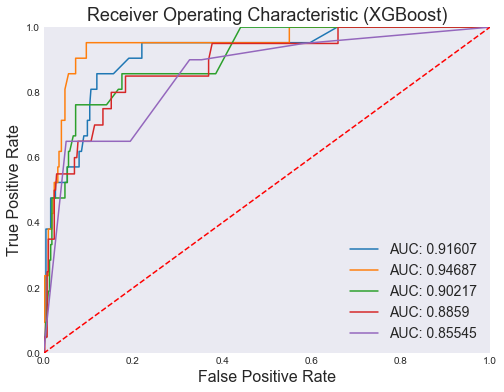

In [61]:
# roc curve
plt.figure(figsize=(8,6))

plt.title('Receiver Operating Characteristic (XGBoost)',fontsize=18)

for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i],label='AUC: {}'.format(round(aucs[i],5)))

plt.legend(loc='lower right',fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=16)
plt.xlabel('False Positive Rate',fontsize=16)
plt.show()

ax.grid(False)